In [1]:
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.psd import aLIGOZeroDetLowPower

# Notes
# (1) Tf2E seems to use 10Hz as reference eccentricity
# (match does not seem to change if changing f_low on tf2e, but does on eccentricfd)

# (2) Tf2E does not seem to use 3.5 PN standard phasing corrections
# (match is high if phase_order set to 6 with no eccentricity)

# (3) Eccentric TD doesn't seem to match the other approximants at low eccentricity!!
# Disregard eccentric TD in lalsimulation?????

p = {'mass1':1.3, 'mass2':1.6,
     'delta_f':1.0/128, 
     'delta_t':1.0/4096,
     'distance':100, 
     'inclination': 0,
     'coa_phase' : 0, 
     'f_lower':9.5,
     'long_asc_nodes':0}

In [2]:
from pycbc.filter import match
import numpy

tlen = 128 * 4096
flen = tlen / 2 + 1

ec = numpy.arange(1e-5, 0.4, .025)
ms = []
for e in ec:
    p['eccentricity'] = e
    hp, hc = get_fd_waveform(approximant="TaylorF2e", **p)
    hp2, hc2 = get_fd_waveform(approximant="EccentricFD", **p)  
    hp2.resize(flen)
    hp.resize(flen)
    psd = aLIGOZeroDetLowPower(flen, hp.delta_f, 30.0)
    m, i = match(hp, hp2, psd=psd, low_frequency_cutoff=30, high_frequency_cutoff=800)
    ms.append(m)
    
    print e, m

1e-05 0.9794031300132451
0.02501 0.981593304946405
0.050010000000000006 0.9858755141679044
0.07501000000000001 0.9870223462711476
0.10001 0.9811388793319622
0.12501 0.9743080187947867
0.15001000000000003 0.9696226919061522
0.17501000000000003 0.9706829026052299
0.20001000000000002 0.9564803809860789
0.22501000000000002 0.8374445482090754
0.25001 0.5510392728515524
0.27501000000000003 0.4590568875540543
0.30001000000000005 0.370421617866172
0.32501 0.29509978687049077
0.35001000000000004 0.25280474727013247
0.37501 0.23160554888082485


In [3]:
import pylab
pylab.plot(ec, ms)
pylab.ylabel('Faithfulness')
pylab.xlabel('Eccentricity (from 10 Hz)')
pylab.show()

<Figure size 640x480 with 1 Axes>

In [4]:
%timeit hp, hc = get_fd_waveform(approximant="TaylorF2e", **p)
%timeit hp2, hc2 = get_fd_waveform(approximant="EccentricFD", **p)

1 loop, best of 3: 223 ms per loop
1 loop, best of 3: 766 ms per loop


In [ ]:
from pycbc.filter import match
import scipy.optimize
import numpy

tlen = 128 * 4096
flen = tlen / 2 + 1
p['eccentricity'] = 0.4

def gl(fl, hp, e):
    fl = fl[0]

    p['f_lower'] = fl
    hp2, hc2 = get_fd_waveform(approximant="EccentricFD", **p)  
    hp2.resize(flen)

    m, i = match(hp, hp2, psd=psd, low_frequency_cutoff=30, high_frequency_cutoff=800)
    print e, fl, m
    return 1-m

def mmin(fun, dt, bounds=None, args=None, *args2, **kwds):
    a, b = bounds[0][0], bounds[0][1]
    vs = numpy.arange(a, b, dt)[::-1]
    minv, mina = 0, 100
    for v in vs:
        a = fun([v], *args)
        if a < mina:
            minv = v
            mina = a
    return minv, mina
                

ec = numpy.arange(1e-5, 0.5, .05)
ms = []
fs = []
for e in ec:
    p['eccentricity'] = e
    hp, hc = get_fd_waveform(approximant="TaylorF2e", **p)
    hp.resize(flen)

    f, m = mmin(gl, .1, args=(hp, e), bounds=[(3, 10.2)])
    #r = scipy.optimize.minimize(gl, [9.5], args=(hp, e), bounds=[(4, 12)], method='Nelder-Mead')
    #f = r['x'][0]
    #m = 1-r['fun']
    ms.append(m)
    fs.append(f)
    print e, f, m



1e-05 10.100000000000007 0.9794031295332294
1e-05 10.000000000000007 0.9794031296153585
1e-05 9.900000000000006 0.9794031296966383
1e-05 9.800000000000006 0.9794031297770645
1e-05 9.700000000000006 0.9794031298566432
1e-05 9.600000000000005 0.9794031299353633
1e-05 9.500000000000005 0.9794031300132451
1e-05 9.400000000000006 0.979403130090281
1e-05 9.300000000000006 0.979403130166466
1e-05 9.200000000000006 0.9794031302418055
1e-05 9.100000000000005 0.9794031303163007
1e-05 9.000000000000005 0.9794031303899512
1e-05 8.900000000000006 0.9794031304627667
1e-05 8.800000000000004 0.9794031305347347
1e-05 8.700000000000005 0.9794031306058589
1e-05 8.600000000000005 0.9794031306761571
1e-05 8.500000000000005 0.9794031307456023
1e-05 8.400000000000006 0.9794031308142168
1e-05 8.300000000000004 0.979403130881993
1e-05 8.200000000000005 0.9794031309489358
1e-05 8.100000000000005 0.9794031310150414
1e-05 8.000000000000004 0.9794031310803144
1e-05 7.900000000000004 0.9794031311447609
1e-05 7.8000

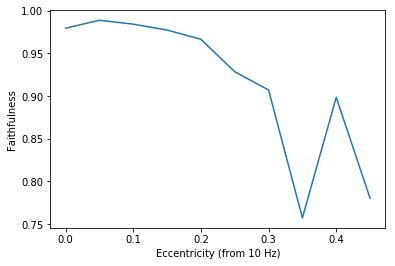

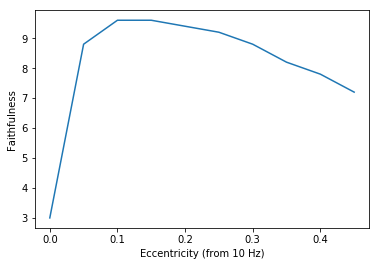

In [7]:
import pylab
pylab.plot(ec, 1-numpy.array(ms))
pylab.ylabel('Faithfulness')
pylab.xlabel('Eccentricity (from 10 Hz)')
pylab.show()

pylab.plot(ec, fs)
pylab.ylabel('Faithfulness')
pylab.xlabel('Eccentricity (from 10 Hz)')
pylab.show()